In [1]:
# Reference: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [80]:
# TRY NOT TO MODIFY: seeding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

# Hyper params
#discrete_action_space_dim = 101
discrete_action_space_dim = 21
input_dim = env.observation_space.shape[0]
#hidden_dim = 765
hidden_dim = 765
output_dim = env.action_space.shape[0] * discrete_action_space_dim
#output_dim = train_env.action_space.shape[0]
print (input_dim, output_dim)

376 357


In [81]:
# env = gym.make('CartPole-v1')
# print (env.observation_space.shape[0], env.action_space.n)

In [91]:
# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        #print ("transition: ", len(transition))
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)
    def flush(self):
        self.buffer.clear()
        
    def len(self):
        return (len(self.buffer))
        

# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_1a = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x, device):
        x = torch.FloatTensor(x).to(device)
        x = torch.tanh(self.fc_1(x))
        x = torch.tanh(self.fc_1a(x))
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


In [92]:
n = discrete_action_space_dim
max_action = 0.4
min_action = -0.4
inc = (max_action - min_action)/ (n-1)
print (inc)
discrete_action_list = [min_action+inc*i for i in range(0, n)]
print (len(discrete_action_list))

0.04
21


In [93]:
def get_actions(action_indices):
    ret_actions = np.zeros(env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = discrete_action_list[index]
    return ret_actions

In [96]:
buffer_size = 100_000
lr = 7.5e-4

rb = ReplayBuffer(buffer_size)
q_network = QNetwork(env).to(device)
target_network = QNetwork(env).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.RMSprop(q_network.parameters(), lr=lr)
#optimizer = optim.Adam(q_network.parameters(), lr=lr)
#loss_fn = nn.MSELoss()
print(device.__repr__())
print(q_network)


# TRY NOT TO MODIFY: start the game
obs = env.reset()
episode_reward = 0
total_timesteps = 10000
start_e = 0.1
end_e = 0.05
exploration_fraction = 0.5
target_network_frequency = 100
batch_size = 10
max_grad_norm = 1.0
gamma = 0.99

episode = 0
episode_rewards = []
step_rewards = []

for global_step in range(total_timesteps):

    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(start_e, end_e, exploration_fraction*total_timesteps, global_step)
    
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q_vals, action_indices = q_network.forward(obs[None, :], device)
        action = get_actions(action_indices.view((-1)))

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, reward, done, _ = env.step(action)
    episode_reward += reward
    step_rewards.append(reward)

    # ALGO LOGIC: training.
   
    rb.put((obs, action, reward, next_obs, done))

    if global_step != 0 and global_step % batch_size == 0:
        s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(batch_size)
        rb.flush()
        with torch.no_grad():
            q_next_val, action_next_indices = target_network.forward(s_next_obses, device)
            action_next = get_actions(action_indices.view((-1)))
            target_max = q_next_val.sum()
            td_target = torch.Tensor(s_rewards).to(device) + gamma * target_max * (1 - torch.Tensor(s_dones).to(device))
        
        old_q, old_action = q_network.forward(s_obs, device)
        #loss = loss_fn(td_target, torch.sum(old_q, 1))
        loss = F.smooth_l1_loss(td_target, torch.sum(old_q, 1))

        # optimize the midel
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(q_network.parameters()), max_grad_norm)
        optimizer.step()
        
    # update the target network
    if global_step % target_network_frequency == 0:
        target_network.load_state_dict(q_network.state_dict())

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook 
    obs = next_obs

    if done:
        episode += 1
        # TRY NOT TO MODIFY: record rewards for plotting purposes
        print(f"episode={episode}, global_step={global_step}, episode_reward={episode_reward}, epsilon={epsilon}")
        episode_rewards.append(episode_reward)
        obs, episode_reward = env.reset(), 0

device(type='cuda')
QNetwork(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_1a): Linear(in_features=765, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=357, bias=True)
  (maxpool): MaxPool1d(kernel_size=21, stride=21, padding=0, dilation=1, ceil_mode=False)
)
episode=1, global_step=19, episode_reward=100.34999951333273, epsilon=0.09981000000000001
episode=2, global_step=36, episode_reward=83.40424886738683, epsilon=0.09964
episode=3, global_step=67, episode_reward=160.6244004159744, epsilon=0.09933
episode=4, global_step=84, episode_reward=84.45847965387591, epsilon=0.09916000000000001
episode=5, global_step=102, episode_reward=87.04797158369975, epsilon=0.09898000000000001
episode=6, global_step=131, episode_reward=138.7376409195177, epsilon=0.09869
episode=7, global_step=169, episode_reward=185.77107958441627, epsilon=0.09831000000000001
episode=8, global_step=208, episode_reward=188.55264131396032, epsilon=0.09792000000000001
episo

episode=96, global_step=3727, episode_reward=192.01113433258044, epsilon=0.06273000000000001
episode=97, global_step=3775, episode_reward=242.80327918663093, epsilon=0.06225
episode=98, global_step=3815, episode_reward=194.38766641313856, epsilon=0.06185
episode=99, global_step=3853, episode_reward=182.54526164857091, epsilon=0.061470000000000004
episode=100, global_step=3893, episode_reward=191.71534273053626, epsilon=0.06107
episode=101, global_step=3937, episode_reward=215.50877258564563, epsilon=0.06063
episode=102, global_step=3974, episode_reward=178.11486734554813, epsilon=0.06026
episode=103, global_step=4016, episode_reward=203.0642055998493, epsilon=0.059840000000000004
episode=104, global_step=4057, episode_reward=197.30259004529825, epsilon=0.059430000000000004
episode=105, global_step=4101, episode_reward=212.7151349570769, epsilon=0.05899
episode=106, global_step=4137, episode_reward=175.57378664219928, epsilon=0.05863
episode=107, global_step=4179, episode_reward=203.999

episode=200, global_step=7975, episode_reward=204.79564367164224, epsilon=0.05
episode=201, global_step=8018, episode_reward=210.18373607833288, epsilon=0.05
episode=202, global_step=8062, episode_reward=213.07970490984593, epsilon=0.05
episode=203, global_step=8101, episode_reward=187.7782848067925, epsilon=0.05
episode=204, global_step=8148, episode_reward=235.53807824742927, epsilon=0.05
episode=205, global_step=8189, episode_reward=196.37685733097848, epsilon=0.05
episode=206, global_step=8229, episode_reward=198.67372462662465, epsilon=0.05
episode=207, global_step=8276, episode_reward=229.4184610888464, epsilon=0.05
episode=208, global_step=8317, episode_reward=204.52695417179217, epsilon=0.05
episode=209, global_step=8358, episode_reward=198.41334626597506, epsilon=0.05
episode=210, global_step=8399, episode_reward=199.97744589570283, epsilon=0.05
episode=211, global_step=8444, episode_reward=222.28253058659868, epsilon=0.05
episode=212, global_step=8485, episode_reward=198.6303

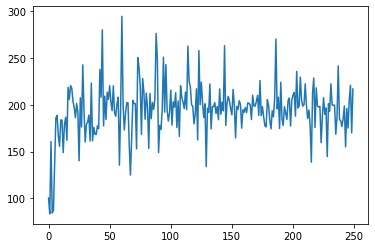

In [97]:
plt.plot(episode_rewards)